Epoch 1/15
39/39 [==============================] - 175s 4s/step - loss: 2.5886 - accuracy: 0.5152 - val_loss: 0.7990 - val_accuracy: 0.5967 - lr: 0.0010
Epoch 2/15
39/39 [==============================] - 110s 3s/step - loss: 1.3109 - accuracy: 0.6583 - val_loss: 0.6119 - val_accuracy: 0.7213 - lr: 0.0010
Epoch 3/15
39/39 [==============================] - 122s 3s/step - loss: 1.0298 - accuracy: 0.7334 - val_loss: 0.5407 - val_accuracy: 0.7311 - lr: 0.0010
Epoch 4/15
39/39 [==============================] - 135s 3s/step - loss: 0.8926 - accuracy: 0.7736 - val_loss: 0.3944 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 5/15
39/39 [==============================] - 142s 4s/step - loss: 0.8333 - accuracy: 0.7847 - val_loss: 0.4516 - val_accuracy: 0.7918 - lr: 0.0010
Epoch 6/15
39/39 [==============================] - 144s 4s/step - loss: 0.7068 - accuracy: 0.8208 - val_loss: 0.3274 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 7/15
39/39 [==============================] - 139s 4s/step - loss: 0.6

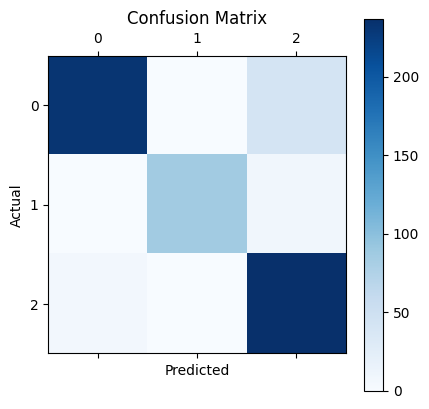

1/1 [==============================] - 0s 139ms/step
Prediction scores: [[0.02398621 0.00321359 0.9728002 ]]
The prediction for the image is: Stone


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, Input
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow as tf

dataset_path = 'C://Users//Divisha//Desktop//dhruv study//DL project//dataset//dataset//dataset'


def load_data(dataset_path):
    images = []
    labels = []
    label_map = {'Normal': 0, 'Tumor': 1, 'Stone': 2}
    
    for label in os.listdir(dataset_path):
        if label in label_map:
            for img_file in os.listdir(os.path.join(dataset_path, label)):
                img_path = os.path.join(dataset_path, label, img_file)
                image = cv2.imread(img_path)
                image = cv2.resize(image, (128, 128))
                images.append(image)
                labels.append(label_map[label])

    return np.array(images), np.array(labels)


X, y = load_data(dataset_path)
X = X / 255.0
y = to_categorical(y, num_classes=3)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


class_weights = {0: 1.0, 1: 4.0, 2: 3.0}  # Adjust for "Normal," "Tumor," "Stone"

datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, 
                             zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')

#
def build_dual_transfer_model():
    
    input_tensor = Input(shape=(128, 128, 3))

   
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    vgg16_base.trainable = False
    vgg16_features = GlobalAveragePooling2D()(vgg16_base.output)

    
    inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    inception_base.trainable = False
    inception_features = GlobalAveragePooling2D()(inception_base.output)

   
    concatenated_features = Concatenate()([vgg16_features, inception_features])

  
    x = Dense(64, activation='relu')(concatenated_features)
    x = Dropout(0.3)(x)
    output = Dense(3, activation='softmax', dtype='float32')(x)  # Softmax for multi-class classification

   
    model = Model(inputs=input_tensor, outputs=output)
    
    return model


model = build_dual_transfer_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_test, y_test),
                    epochs=15,
                    class_weight=class_weights,
                    callbacks=[early_stopping, reduce_lr])

model.save('multi_class_dual_transfer_model.keras')
with open('training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


def evaluate_model(X_test, y_test, model):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=["Normal", "Tumor", "Stone"])

    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)

    plt.matshow(cm, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


def predict_image(image_path, model):
    img = cv2.imread(image_path)
    if img is None:
        return "Error: Image not found."
    
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    class_labels = ["Normal", "Tumor", "Stone"]
    predicted_class = class_labels[np.argmax(prediction)]
    print("Prediction scores:", prediction)
    return predicted_class


evaluate_model(X_test, y_test, model)

# Example single image prediction
image_path = "C://Users//Divisha//Downloads//Test_DL//Stone//Stone- (1377).jpg" # Replace with actual path
prediction = predict_image(image_path, model)
print(f'The prediction for the image is: {prediction}')
